We explored a few different ways to work with larger datasets in pandas. In this project, we'll practice using some of the techniques we learned to analyze startup investments from Crunchbase.com.

Every year, thousands of startup companies raise financing from investors. Each time a startup raises money, we refer to the event as a fundraising round. Crunchbase is a website that crowdsources information on the fundraising rounds of many startups. The Crunchbase user community submits, edits, and maintains most of the information in Crunchbase.

In return, Crunchbase makes the data available through a Web application and a fee-based API. Before Crunchbase switched to the paid API model, multiple groups crawled the site and released the data online. Because the information on the startups and their fundraising rounds is always changing, the data set we'll be using isn't completely up to date.

The data set of investments we'll be exploring is current as of October 2013. We can download it from [GitHub](https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv).

Throughout this project, we'll practice working with different memory constraints. In this step, let's assume we only have 10 megabytes of available memory. While `crunchbase-investments.csv` consumes 10.3 megabytes of disk space, we know from earlier files that pandas often requires 4 to 6 times amount of space in memory as the file does on disk (especially when there's many string columns).

[Solution](https://github.com/dataquestio/solutions/blob/master/Mission167Solutions.ipynb)

**Task**

* Because the data set contains over 50,000 rows, we'll need to read the data set into dataframes using 5,000 row chunks to ensure that each chunk consumes much less than 10 megabytes of memory.
* Across all of the chunks, become familiar with:
    * Each column's missing value counts
    * Each column's memory footprint
    * The total memory footprint of all of the chunks combined
    * Which column(s) we can drop because they aren't useful for analysis
    
**Answer**

In [1]:
import pandas as pd
pd.options.display.max_columns = 99
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='ISO-8859-1')

### Compute each column's missing value counts

In [2]:
mv_list = []

for chunk in chunk_iter:
    mv_list.append(chunk.isnull().sum())
    
combined_mv_vc = pd.concat(mv_list)

unique_combined_mv_vc = combined_mv_vc.groupby(combined_mv_vc.index).sum()
unique_combined_mv_vc.sort_values()

company_country_code          1
company_name                  1
company_permalink             1
company_region                1
investor_region               2
investor_permalink            2
investor_name                 2
funded_quarter                3
funded_at                     3
funded_month                  3
funded_year                   3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64

### Total memory footprint for each column

In [3]:
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='ISO-8859-1')
counter = 0
series_memory_fp = pd.Series(dtype='float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else:
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

# Drop memory footprint calculation for the index.
series_memory_fp = series_memory_fp.drop('Index')
series_memory_fp

company_permalink         4057788
company_name              3591326
company_category_code     3421104
company_country_code      3172176
company_state_code        3106051
company_region            3411545
company_city              3505886
investor_permalink        4980548
investor_name             3915666
investor_category_code     622424
investor_country_code     2647292
investor_state_code       2476607
investor_region           3396281
investor_city             2885083
funding_round_type        3410707
funded_at                 3542185
funded_month              3383584
funded_quarter            3383584
funded_year                422960
raised_amount_usd          422960
dtype: int64

### Total memory footprint of the data (in megabytes)

In [4]:
series_memory_fp.sum() / (1024 * 1024)

56.98753070831299

In [5]:
unique_combined_mv_vc.sort_values()

company_country_code          1
company_name                  1
company_permalink             1
company_region                1
investor_region               2
investor_permalink            2
investor_name                 2
funded_quarter                3
funded_at                     3
funded_month                  3
funded_year                   3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64

### Drop columns representing URL's or containing way too many missing values (>90% missing)

In [6]:
drop_cols = ['investor_permalink', 'company_permalink', 'investor_category_code']
keep_cols = chunk.columns.drop(drop_cols)

In [7]:
keep_cols.tolist

<bound method IndexOpsMixin.tolist of Index(['company_name', 'company_category_code', 'company_country_code',
       'company_state_code', 'company_region', 'company_city', 'investor_name',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_type', 'funded_at', 'funded_month',
       'funded_quarter', 'funded_year', 'raised_amount_usd'],
      dtype='object')>

### Selecting Data Types

Now that we have a good sense of the missing values, let's get familiar with the column types before adding the data into SQLite.

**Task**

* Identify the types for each column.
* Identify the numeric columns we can represent using more space efficient types.
* For text columns:
    * Analyze the unique value counts across all of the chunks to see if we can convert them to a numeric type.
    * See if we clean clean any text columns and separate them into multiple numeric columns without adding any overhead when querying.
* Make our changes to the code from the last step so that the overall memory the data consumes stays under 10 megabytes.

**Answer**

### Let's first determine which columns shift types across chunks. Note that we only lay the groundwork for this step

In [8]:
# Key: Column name, Value: List of types

col_types = {}
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000,
                         encoding='ISO-8859-1', usecols=keep_cols)

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in col_types:
            col_types[col] = [str(chunk.dtypes[col])]
        else:
            col_types[col].append(str(chunk.dtypes[col]))

In [9]:
uniq_col_types = {}

for k,v in col_types.items():
    uniq_col_types[k] = set(col_types[k])
    
uniq_col_types

{'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_name': {'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'funded_month': {'object'},
 'funded_quarter': {'object'},
 'funded_year': {'float64', 'int64'},
 'raised_amount_usd': {'float64'}}

In [10]:
chunk

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
50000,NuORDER,fashion,USA,CA,Los Angeles,West Hollywood,Mortimer Singer,NaN,NaN,unknown,NaN,series-a,2012-10-01,2012-10,2012-Q4,2012,3060000.0
50001,ChaCha,advertising,USA,IN,Indianapolis,Carmel,Morton Meyerson,NaN,NaN,unknown,NaN,series-b,2007-10-01,2007-10,2007-Q4,2007,12000000.0
50002,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2008-04-18,2008-04,2008-Q2,2008,500000.0
50003,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2010-01-01,2010-01,2010-Q1,2010,750000.0
50004,Unified Color,software,USA,CA,SF Bay,South San Frnacisco,Mr. Andrew Oung,NaN,NaN,unknown,NaN,angel,2010-01-01,2010-01,2010-Q1,2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52865,Garantia Data,enterprise,USA,CA,SF Bay,Santa Clara,Zohar Gilon,NaN,NaN,unknown,NaN,series-a,2012-08-08,2012-08,2012-Q3,2012,3800000.0
52866,DudaMobile,mobile,USA,CA,SF Bay,Palo Alto,Zohar Gilon,NaN,NaN,unknown,NaN,series-c+,2013-04-08,2013-04,2013-Q2,2013,10300000.0
52867,SiteBrains,software,USA,CA,SF Bay,San Francisco,zohar israel,NaN,NaN,unknown,NaN,angel,2010-08-01,2010-08,2010-Q3,2010,350000.0
52868,Comprehend Systems,enterprise,USA,CA,SF Bay,Palo Alto,Zorba Lieberman,NaN,NaN,unknown,NaN,series-a,2013-07-11,2013-07,2013-Q3,2013,8400000.0


## Loading Chunks Into SQLite

Now we're in good shape to start exploring and analyzing the data. The next step is to load each chunk into a table in a SQLite database so we can query the full data set.

**Task**

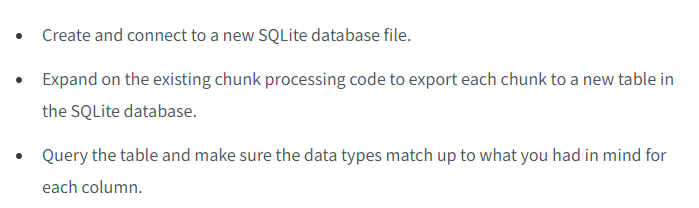

**Answer**

In [11]:
import sqlite3
conn = sqlite3.connect('crunchbase.db')
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='ISO-8859-1')

for chunk in chunk_iter:
    chunk.to_sql("investments", conn, if_exists='append', index=False)

Now that the data is in SQLite, we can use the pandas SQLite workflow we learned in the last file to explore and analyze startup investments. Remember that each row isn't a unique company, but a unique investment from a single investor. This means that many startups will span multiple rows.

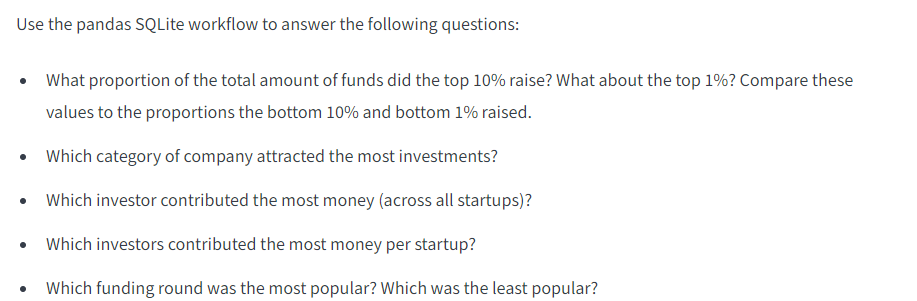

Here are some ideas for further exploration:

* Repeat the tasks in this project using stricter memory constraints (under 1 megabyte).
* Clean and analyze the other Crunchbase data sets from the same [GitHub](https://github.com/datahoarder/crunchbase-october-2013) repo.
    * Understand which columns the data sets share, and how the data sets are linked.
    * Create a relational database design that links the data sets together and reduces the overall disk space the database file consumes.
    * Use pandas to populate each table in the database, create the appropriate indexes, and so on.